# 4a Walk Through Analyses with Binary TaCo

Imports & path variables etc

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from sciplotlib import style
import seaborn as sns
from dtreeviz.trees import dtreeviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import make_scorer, roc_auc_score

from julearn.transformers.confounds import DataFrameConfoundRemover

from PIL import Image
from cairosvg import svg2png

from leakconfound.analyses.utils import save_paper_val
from leakconfound.plotting import mm_to_inch
from leakconfound.transformers import Shuffle
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

mpl.style.use(style.get_style("nature-reviews"))
mpl.rc("xtick", labelsize=11)
mpl.rc("ytick", labelsize=11)
mpl.rc("axes", labelsize=12, titlesize=12)
mpl.rc("figure", dpi=300)
mpl.rc("figure.subplot", wspace=mm_to_inch(4), hspace=mm_to_inch(7))
mpl.rc("lines", linewidth=1)

colors = [
    "#E64B35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2FF",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]

project_base = "../../"
out_base = f"{project_base}analyses/content/saved_figures/"
base_save_paper = "./paper_val/"

dt_colors = [
    None,  # 0 classes
    None,  # 1 class
    [purple, green],  # 2 classes
]

Define functions for plotting:

In [2]:

def plot_scatter(x, y, df, threshold, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    sns.stripplot(
        x=x,
        y=y,
        data=df,
        orient="h",
        **kwargs,
        ax=ax,
        edgecolor="w",
        linewidth=0.05,
        palette=[purple, green],
    )
    ax.set_xlabel(f"{x}")
    ax.set_ylabel("")
    ax.legend(loc="upper right")

    ax.axvline(x=threshold, color="grey", linestyle="--", lw=3)
    ax.annotate(
        f"{threshold:.3f}",
        xy=(threshold, 0.01),
        xytext=(threshold, -0.045),
        xycoords=ax.get_xaxis_transform(),
        verticalalignment="top",
        ha="center",
        arrowprops=dict(arrowstyle="->", color="grey", linewidth=1),
        bbox=dict(boxstyle="round", fc="w", color="grey"),
        fontsize=15,
        weight="semibold",
    )
    ax.tick_params(axis="both", which="major", labelsize=20)


def plot_discont(X, hue, data, left_lim, right_lim, colors=None, title=""):
    palette = [purple, green] if colors is None else colors
    y = hue
    df_left = data.query(f"{X} < {left_lim[1]}").copy()
    df_right = data.query(f"{X} > {right_lim[0]}").copy()
    assert len(df_left) + len(df_right) == len(data)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5], sharey=True)
    fig.subplots_adjust(wspace=0.05)
    fig.suptitle(title)
    sns.stripplot(
        x=X,
        y=y,
        data=df_left,
        ax=ax1,
        palette=palette,
        orient="h",
        edgecolor="w",
        linewidth=0.05,
    )
    sns.stripplot(
        x=X,
        y=y,
        data=df_right,
        edgecolor="w",
        orient="h",
        linewidth=0.05,
        ax=ax2,
        palette=palette,
    )

    ax1.axvline(x=left_lim[1], color="grey", linestyle="--", lw=3)
    ax1.set_xlim(left_lim[0], left_lim[1])
    ax1.spines.right.set_visible(False)
    ax1.set_yticklabels([])
    ax1.set_ylabel("")
    ax1.tick_params(left=False)

    # ax2
    ax2.spines.left.set_visible(False)
    ax2.yaxis.tick_left()
    ax2.tick_params(left=False)
    ax2.set_xlim(right_lim[0], right_lim[1])

    d = 1.5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(
        marker=[(-1, -d), (1, d)],
        markersize=12,
        linestyle="none",
        color="k",
        mec="k",
        mew=1,
        clip_on=False,
    )
    ax1.plot([1], [0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0], [0], transform=ax2.transAxes, **kwargs)

    # titles
    ax1.set_xlabel("")
    ax2.set_xlabel("")

    return fig, (ax1, ax2)


Prepare data

In [3]:

np.random.seed(3240987)
auc_scorer = make_scorer(roc_auc_score)
df = pd.read_csv(f"{project_base}data/uci_datasets/bank.csv")


col_names = [col.split("__")[0] for col in df.columns.tolist()]
df.columns = col_names
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], train_size=0.7, stratify=df.iloc[:, -1]
)

Standardize, Shuffle, add Noise for Suppression

In [4]:
zscore = StandardScaler().fit(X_train, y_train)
X_train = pd.DataFrame(zscore.transform(X_train), columns=col_names[:-1])
X_test = pd.DataFrame(zscore.transform(X_test), columns=col_names[:-1])
shuffler = Shuffle().fit(X_train)
X_train_shuffled = shuffler.transform(X_train)
zscore_shuffled = StandardScaler().fit(X_train_shuffled, y_train)
X_train_shuffled = pd.DataFrame(
    zscore.transform(X_train_shuffled), columns=col_names[:-1]
)
X_test_shuffled = shuffler.transform(X_test)
X_test_shuffled = pd.DataFrame(
    zscore.transform(X_test_shuffled), columns=col_names[:-1]
)

noise = np.random.normal(scale=2, size=(len(X_train), 1))
X_train_suppression = X_train + noise


In [5]:
shuffler_suppression = Shuffle().fit(X_train_suppression)
X_train_suppression_shuffled = shuffler_suppression.transform(X_train_suppression)
zscore_supression_shuffled = StandardScaler().fit(X_train_suppression_shuffled, y_train)
X_train_suppression_shuffled = (
    pd.DataFrame(zscore.transform(X_train_suppression_shuffled), columns=col_names[:-1])
    + noise
)

X_train_suppression["noise__:type:__confound"] = noise
X_train_suppression_shuffled["noise__:type:__confound"] = noise


noise = np.random.normal(scale=2, size=(len(X_test), 1))


X_test_suppression = X_test + noise

X_test_suppression_shuffled = shuffler_suppression.transform(X_test_suppression)
X_test_suppression_shuffled = (
    pd.DataFrame(zscore.transform(X_test_suppression_shuffled), columns=col_names[:-1])
    + noise
)

X_test_suppression["noise__:type:__confound"] = noise
X_test_suppression_shuffled["noise__:type:__confound"] = noise

#  Remove TaCo

In [6]:
# Apply TaCo


def prep_taco(X, y):
    return X.copy().assign(**{"TaCo__:type:__confound": y.values})


CR = DataFrameConfoundRemover().fit(prep_taco(X_train, y_train))
CR_shuffled = DataFrameConfoundRemover().fit(prep_taco(X_train_shuffled, y_train))
CR_suppression = DataFrameConfoundRemover().fit(X_train_suppression, y_train)
CR_suppression_shuffled = DataFrameConfoundRemover().fit(
    X_train_suppression_shuffled, y_train
)


X_train_TaCo = CR.transform(prep_taco(X_train, y_train))
y_train_TaCo = y_train.reset_index(drop=True)

X_test_TaCo = CR.transform(prep_taco(X_test, y_test))
y_test_TaCo = y_test.reset_index(drop=True)


X_train_TaCo_shuffled = CR_shuffled.transform(prep_taco(X_train_shuffled, y_train))
X_test_TaCo_shuffled = CR_shuffled.transform(prep_taco(X_test_shuffled, y_test))
X_train_CR_suppression = CR_suppression.transform(X_train_suppression)
X_test_CR_suppression = CR_suppression.transform(X_test_suppression)

x_train_CR_suppression_shuffled = CR_suppression_shuffled.transform(
    X_train_suppression_shuffled
)
X_test_CR_suppression_shuffled = CR_suppression_shuffled.transform(
    X_test_suppression_shuffled
)


Model and Score

In [7]:
print("original features")
dt_raw = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
score_X = auc_scorer(dt_raw, X_test, y_test)
print("Raw", score_X)
save_paper_val(
    base_save_paper, "walk_through_binary", "raw", "dt.txt", round(score_X, 2)
)

dt_taco = DecisionTreeClassifier(max_depth=2).fit(X_train_TaCo, y_train_TaCo)
score_Xcr = auc_scorer(dt_taco, X_test_TaCo, y_test_TaCo)
print("TaCo", score_Xcr)
save_paper_val(
    base_save_paper, "walk_through_binary", "removed", "dt.txt", round(score_Xcr, 2)
)

save_paper_val(
    base_save_paper,
    "walk_through_bianry",
    "raw_v_rem",
    "median_pearsonr.txt",
    X_train.corrwith(X_train_TaCo).median(),
)


original features
Raw 0.7539511494252874
TaCo 0.978448275862069


In [8]:
print("shuffled")
dt_raw_shuff = DecisionTreeClassifier(max_depth=2).fit(X_train_shuffled, y_train)
score_X_shuff = auc_scorer(dt_raw_shuff, X_test_shuffled, y_test)
print("Raw", score_X_shuff)

save_paper_val(
    base_save_paper,
    "walk_through_binary",
    "raw",
    "dt_shuffled.txt",
    round(score_X_shuff, 2),
)

dt_taco_shuff = DecisionTreeClassifier(max_depth=2).fit(
    X_train_TaCo_shuffled, y_train_TaCo
)

score_X_rem_shuff = auc_scorer(dt_taco_shuff, X_test_TaCo_shuffled, y_test_TaCo)
print("TaCo", score_X_rem_shuff)
save_paper_val(
    base_save_paper,
    "walk_through_binary",
    "removed",
    "dt_shuffled.txt",
    round(score_X_rem_shuff, 2),
)


shuffled
Raw 0.4802442528735632


TaCo 0.9913793103448276


In [9]:
print("suppression")
dt_raw_sup = DecisionTreeClassifier(max_depth=2).fit(X_train_suppression, y_train)
score_X_sup = auc_scorer(dt_raw_sup, X_test_suppression, y_test)
print("Raw", score_X_sup)

save_paper_val(
    base_save_paper,
    "walk_through_binary",
    "raw",
    "dt_suppression.txt",
    round(score_X_sup, 2),
)
dt_sup = DecisionTreeClassifier(max_depth=2).fit(X_train_CR_suppression, y_train_TaCo)

score_X_sup_rem = auc_scorer(dt_sup, X_test_CR_suppression, y_test)
print("CR: Suppression", score_X_sup_rem)

save_paper_val(
    base_save_paper,
    "walk_through_binary",
    "removed",
    "dt_suppression.txt",
    round(score_X_sup_rem, 2),
)

suppression
Raw 0.6580459770114943
CR: Suppression 0.7553879310344828


In [10]:
print("shuffled suppression")
dt_raw_sup_shuff = DecisionTreeClassifier(max_depth=2).fit(
    X_train_suppression_shuffled, y_train
)
score_X_sup_shuff = auc_scorer(dt_raw_sup_shuff, X_test_suppression_shuffled, y_test)
print("Raw", score_X_sup_shuff)

save_paper_val(
    base_save_paper,
    "walk_through_binary",
    "raw",
    "dt_suppression_shuffled.txt",
    round(score_X_sup_shuff, 2),
)
dt_sup_shuff = DecisionTreeClassifier(max_depth=2).fit(
    x_train_CR_suppression_shuffled, y_train_TaCo
)

score_X_sup_rem_shuff = auc_scorer(dt_sup_shuff, X_test_CR_suppression_shuffled, y_test)
print("CR: Suppression", score_X_sup_rem_shuff)

save_paper_val(
    base_save_paper,
    "walk_through_binary",
    "removed",
    "dt_suppression_shuffled.txt",
    round(score_X_sup_rem_shuff, 2),
)


shuffled suppression
Raw 0.4964080459770115
CR: Suppression 0.5007183908045977


Looking at the Decision Trees

In [11]:
viz_raw = dtreeviz(
    dt_raw,
    X_test,
    y_test,
    target_name="Subscribed to Deposit",
    feature_names=col_names[:-1],
    histtype="strip",
    scale=4,
    colors={"classes": dt_colors},
    class_names={0: "no", 1: "yes"},
)
viz_raw.save(f"{out_base}dt_raw_bank.svg")


viz_taco = dtreeviz(
    dt_taco,
    X_test_TaCo,
    y_test_TaCo,
    target_name="Subscribed to Deposit",
    feature_names=col_names[:-1],
    histtype="strip",
    scale=4,
    colors={"classes": dt_colors},
    class_names={0: "no", 1: "yes"},
)
viz_taco.save(f"{out_base}dt_taco_bank.svg")

idx = X_test_TaCo.index
df_TaCo_plot = (
    X_test_TaCo.assign(y=y_test_TaCo.values).loc[idx, :].reset_index(drop=True)
)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


## Detailed Look At Decions Tree Notes
### Before Removal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


|--- duration <= -0.51
|   |--- nr_employed <= -0.56
|   |   |--- class: 1
|   |--- nr_employed >  -0.56
|   |   |--- class: 0
|--- duration >  -0.51
|   |--- euribor3m <= -0.03
|   |   |--- class: 1
|   |--- euribor3m >  -0.03
|   |   |--- class: 1



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


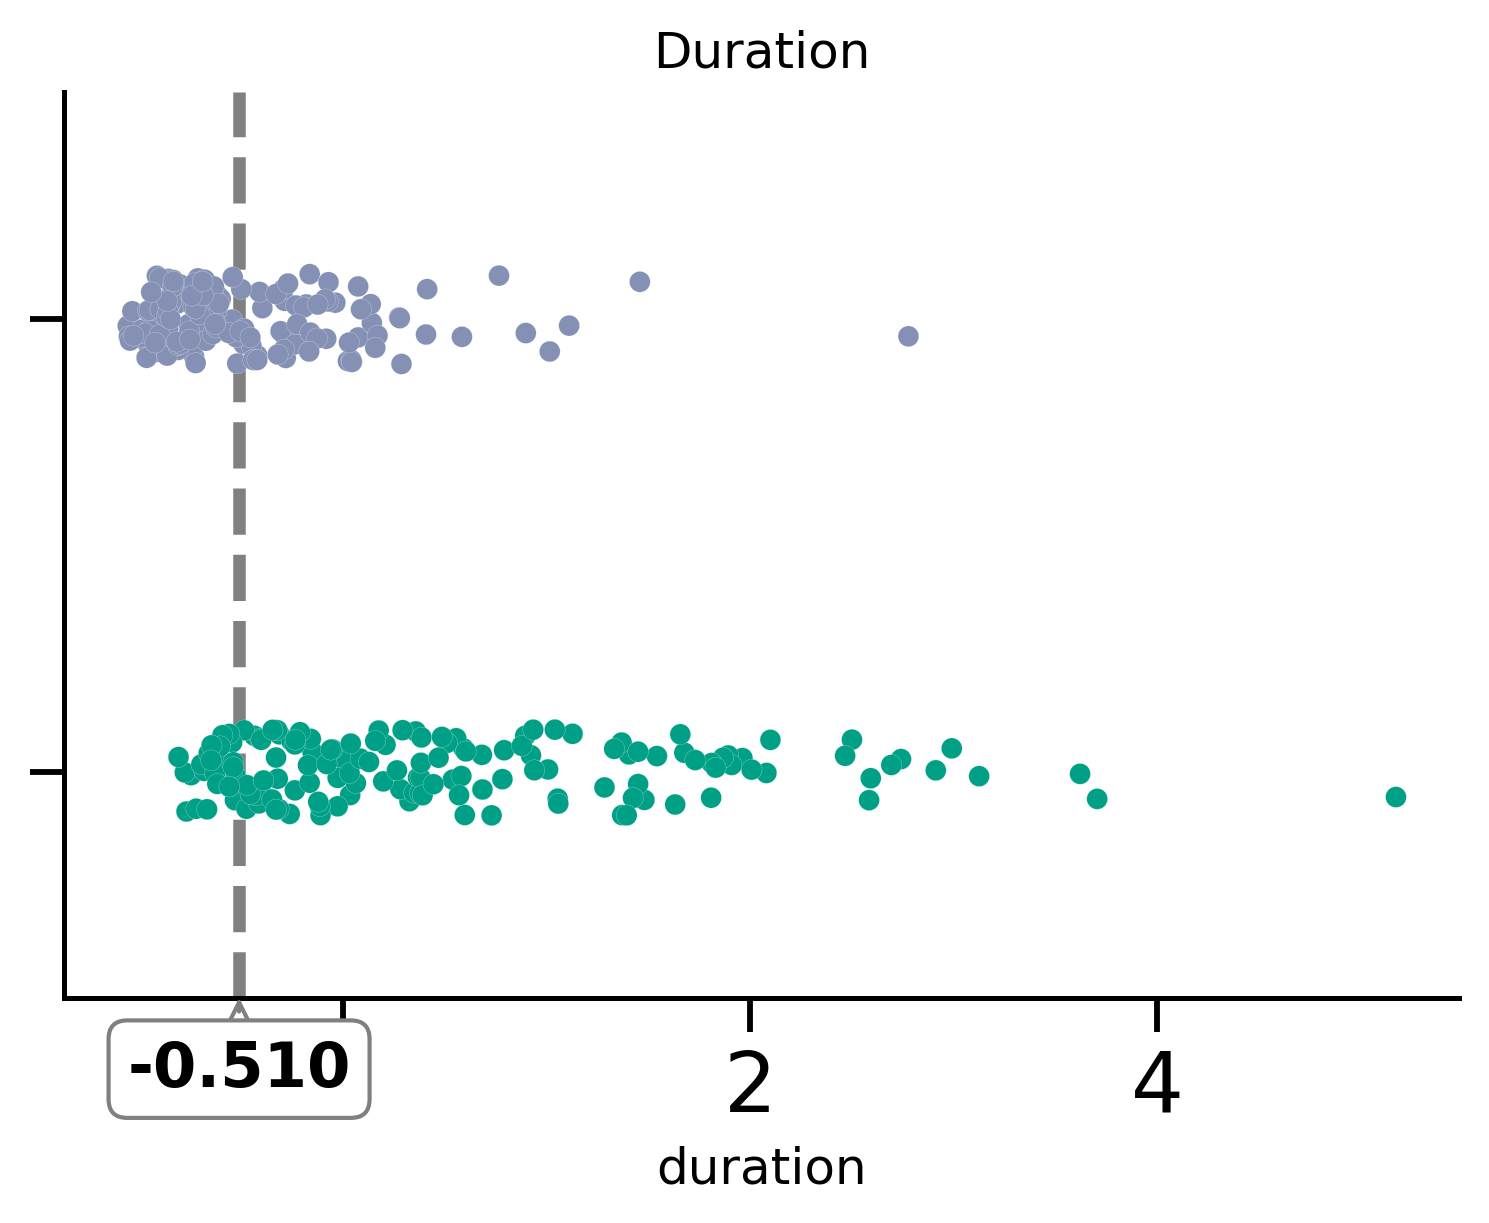

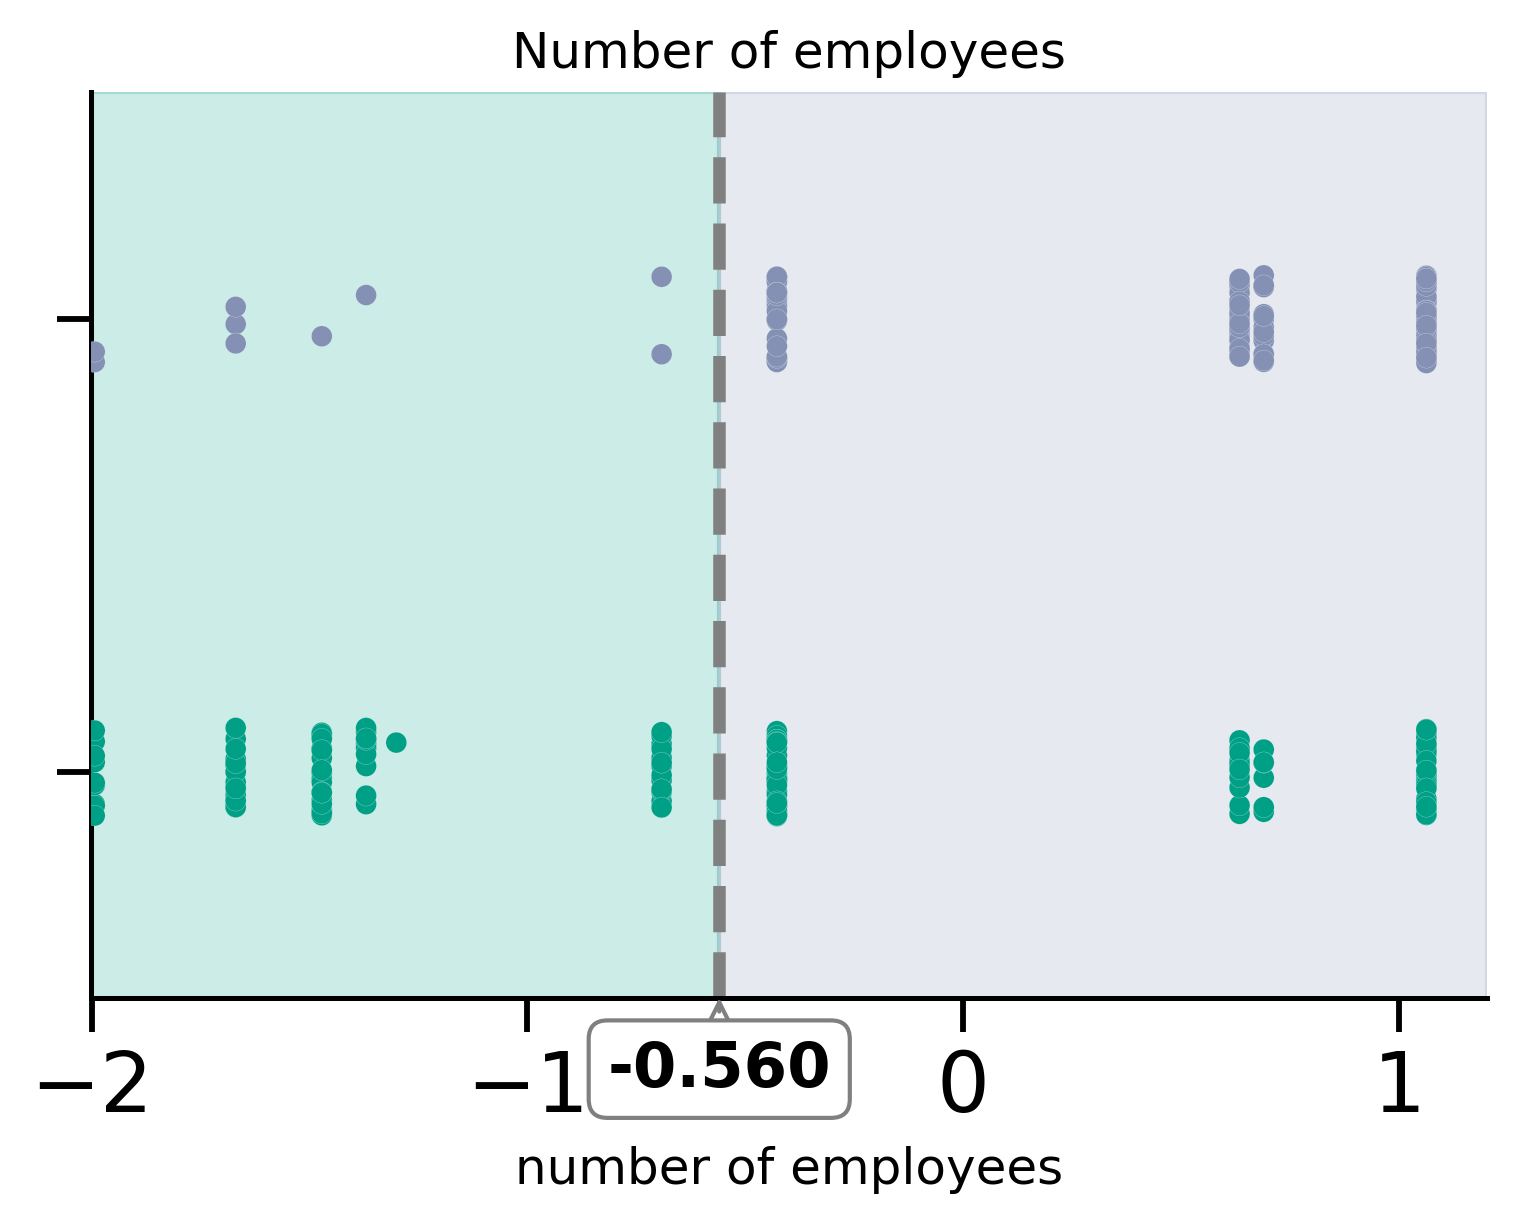

In [12]:

svg2png(
    file_obj=open(f"{out_base}dt_raw_bank.svg", "rb"),
    write_to=f"{out_base}dt_raw_bank.png",
)
svg2png(
    file_obj=open(f"{out_base}dt_taco_bank.svg", "rb"),
    write_to=f"{out_base}dt_taco_bank.png",
)

idx = X_test.sample(300, random_state=185123).index
df_test_plot = (
    X_test.assign(y=y_test.values)
    .iloc[idx, :]
    .rename(columns=dict(euribor3m="euribor", nr_employed="number of employees"))
)
# thresholds from here:
print(export_text(dt_raw, feature_names=X_test.columns.to_list()))
fig, ax = plt.subplots()
threshold = -0.51
plot_scatter(x="duration", y="y", df=df_test_plot, threshold=threshold, ax=ax)
# ax.set_xlim(-.1, 1)
ax.set_title("Duration")
# ax.axvspan(-.1, threshold, color=green, alpha=.2)
# ax.axvspan(threshold, 1, color=purple, alpha=.2)
ax.set_yticklabels([])
ax.set_ylabel("")
fig.savefig(f"{out_base}/dt_raw_duration.png")
fig.savefig(f"{out_base}/dt_raw_duration.svg")


fig, ax = plt.subplots()
threshold = -0.56
plot_scatter(
    x="number of employees", y="y", df=df_test_plot, threshold=threshold, ax=ax
)

ax.set_title("Number of employees")
ax.set_xlim(-2, 1.2)
ax.axvspan(-2, threshold, color=green, alpha=0.2)
ax.axvspan(threshold, 1.2, color=purple, alpha=0.2)
ax.set_yticklabels([])
ax.set_ylabel("")

fig.savefig(f"{out_base}/dt_raw_nremployed.png")
fig.savefig(f"{out_base}/dt_raw_nremployed.svg")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


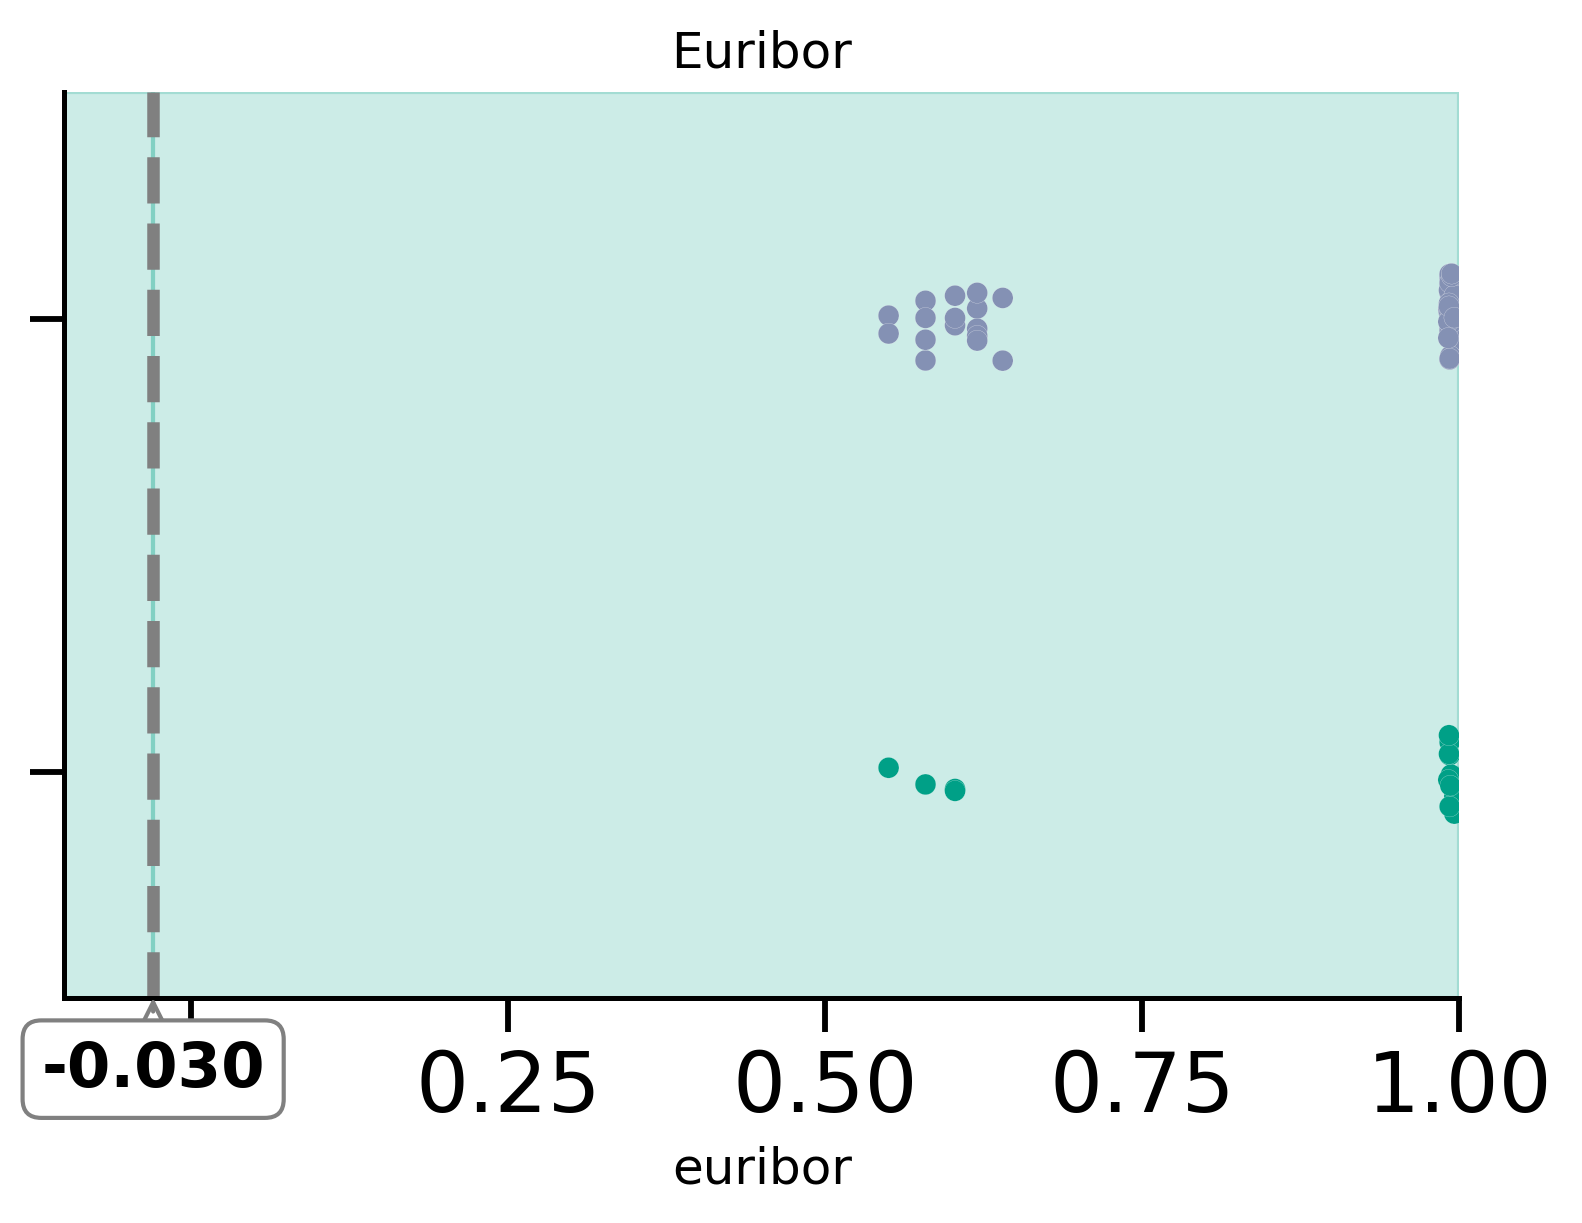

In [13]:
fig, ax = plt.subplots()
threshold = -0.03
plot_scatter(
    x="euribor",
    y="y",
    df=df_test_plot,
    threshold=threshold,
    ax=ax,
)
ax.set_title("Euribor")
ax.set_xlim(-0.1, 1)
ax.axvspan(-0.1, threshold, color=green, alpha=0.2)
ax.axvspan(threshold, 1, color=green, alpha=0.2)
ax.set_yticklabels([])
ax.set_ylabel("")

fig.savefig(f"{out_base}/dt_raw_euribor.png")
fig.savefig(f"{out_base}/dt_raw_euribor.svg")

img_raw = Image.open(f"{out_base}dt_raw_bank.png", "r")
img_taco = Image.open(f"{out_base}dt_taco_bank.png", "r")


### After TaCo Removal

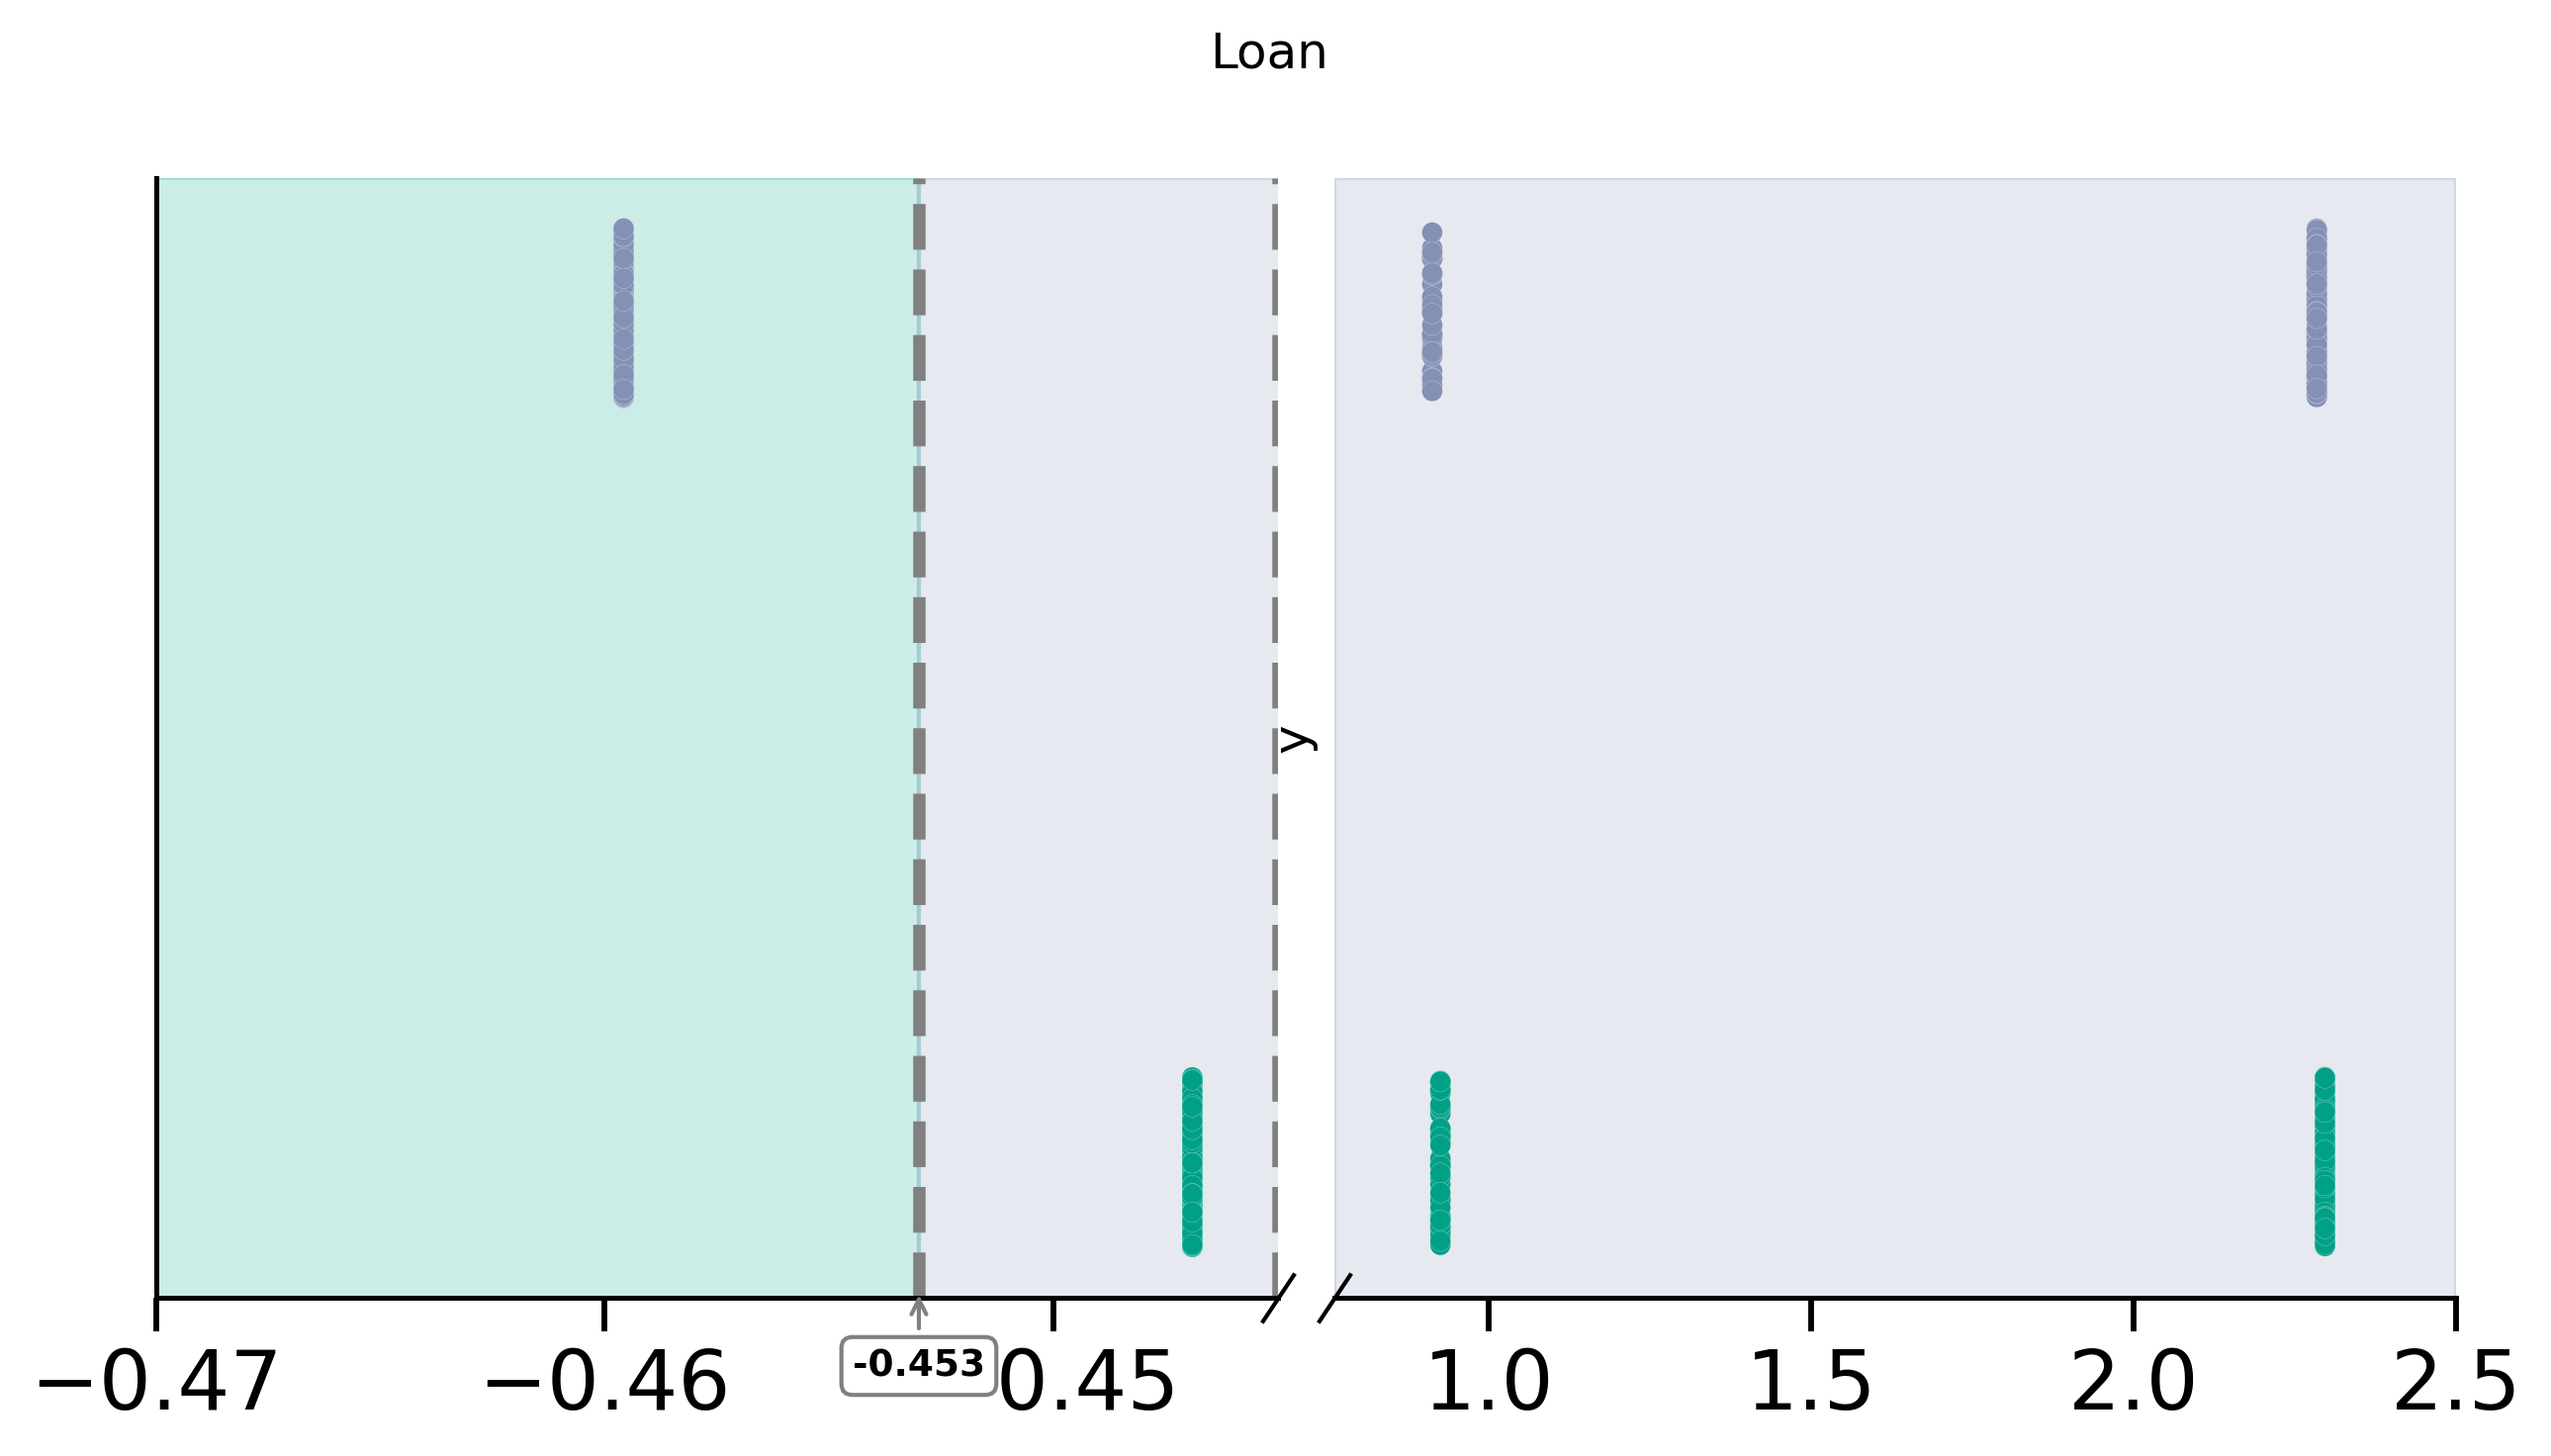

In [14]:
fig, (ax1, ax2) = plot_discont(
    "loan",
    "y",
    df_TaCo_plot,
    (-0.47, -0.445),
    (0.76, 2.5),
    colors=[purple, green],
    title="Loan",
)

ax1.axvline(x=-0.453, color="grey", linestyle="--", lw=3)
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))


ax1.axvspan(-0.48, -0.453, color=green, alpha=0.2)
ax1.axvspan(-0.453, -0.39, color=purple, alpha=0.2)
ax2.axvspan(0.76, 2.5, color=purple, alpha=0.2)

ax1.tick_params(axis="both", which="major", labelsize=20)
ax2.tick_params(axis="both", which="major", labelsize=20)

ax1.annotate(
    "-0.453",
    xy=(-0.453, 0.01),
    xytext=(-0.453, -0.045),
    xycoords=ax1.get_xaxis_transform(),
    verticalalignment="top",
    ha="center",
    arrowprops=dict(arrowstyle="->", color="grey", linewidth=1),
    bbox=dict(boxstyle="round", fc="w", color="grey"),
    fontsize=9,
    weight="semibold",
)


fig.savefig(f"{out_base}/dt_taco_loan.svg")
fig.savefig(f"{out_base}/dt_taco_loan.png")

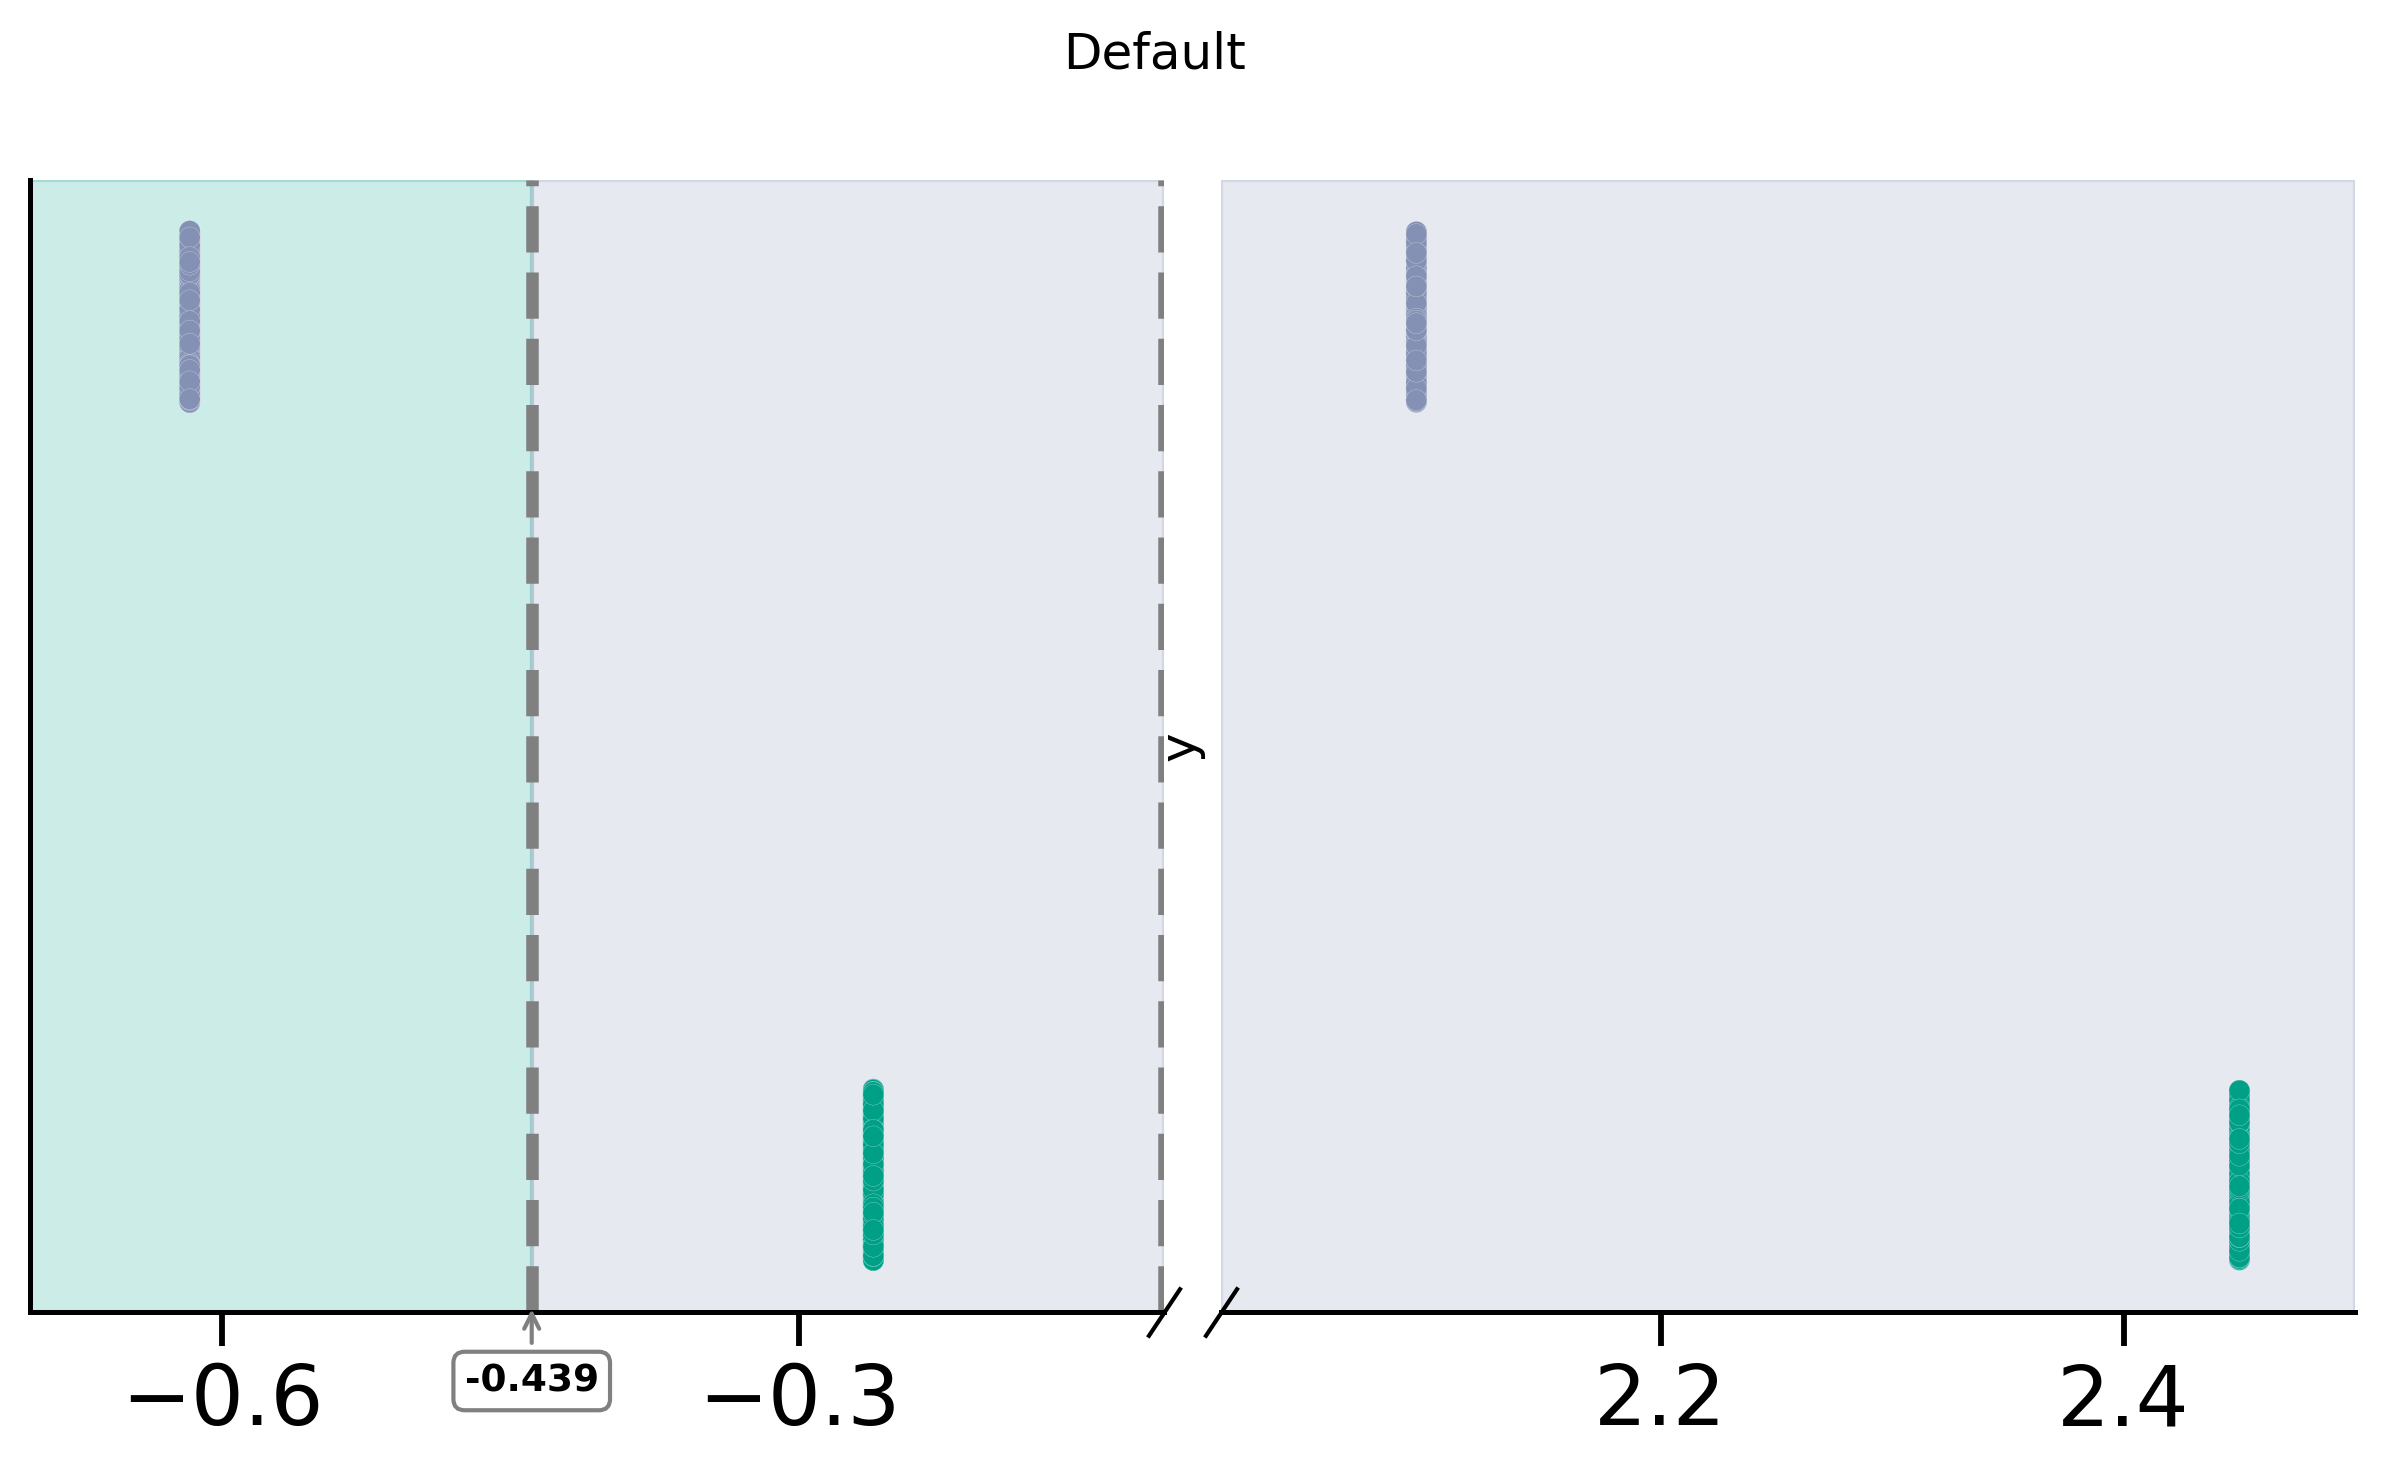

In [15]:
fig2, (ax12, ax22) = plot_discont(
    "default",
    "y",
    df_TaCo_plot,
    (-0.7, -0.11),
    (2.01, 2.5),
    colors=[purple, green],
    title="Default",
)

ax12.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.3))
ax12.axvline(x=-0.439, color="grey", linestyle="--", lw=3)
ax12.axvspan(-0.7, -0.439, color=green, alpha=0.2)
ax12.axvspan(-0.439, -0.11, color=purple, alpha=0.2)
ax22.axvspan(2.01, 2.5, color=purple, alpha=0.2)

ax12.tick_params(axis="both", which="major", labelsize=20)
ax22.tick_params(axis="both", which="major", labelsize=20)

ax12.annotate(
    "-0.439",
    xy=(-0.439, 0.01),
    xytext=(-0.439, -0.045),
    xycoords=ax12.get_xaxis_transform(),
    verticalalignment="top",
    ha="center",
    arrowprops=dict(arrowstyle="->", color="grey", linewidth=1),
    bbox=dict(boxstyle="round", fc="w", color="grey"),
    fontsize=9,
    weight="semibold",
)

fig2.savefig(f"{out_base}/dt_taco_default.svg")
fig2.savefig(f"{out_base}/dt_taco_default.png")


Compute, model and score on Xhat:

In [16]:
# Score plots

est_removal = CR.models_confound_

X_hat_train = est_removal.apply(
    lambda model: model.predict(y_train.values.reshape(-1, 1))
).pipe(lambda df: pd.DataFrame({row: col for row, col in df.iteritems()}))

X_hat_test = est_removal.apply(
    lambda model: model.predict(y_test.values.reshape(-1, 1))
).pipe(lambda df: pd.DataFrame({row: col for row, col in df.iteritems()}))
X_hat_train.index = X_train.index
X_hat_test.index = X_test.index

dt_Xhat = DecisionTreeClassifier(max_depth=2).fit(X_hat_train, y_train)
score_Xhat = dt_Xhat.score(X_hat_test, y_test)

save_paper_val(
    base_save_paper, "walk_through_binary", "removed", "dt_Xhat.txt", score_Xhat
)
print("Xhat scored:", score_Xhat)

Xhat scored: 1.0


Plotting

(0.0, 1.0)

<Figure size 7500x6000 with 0 Axes>

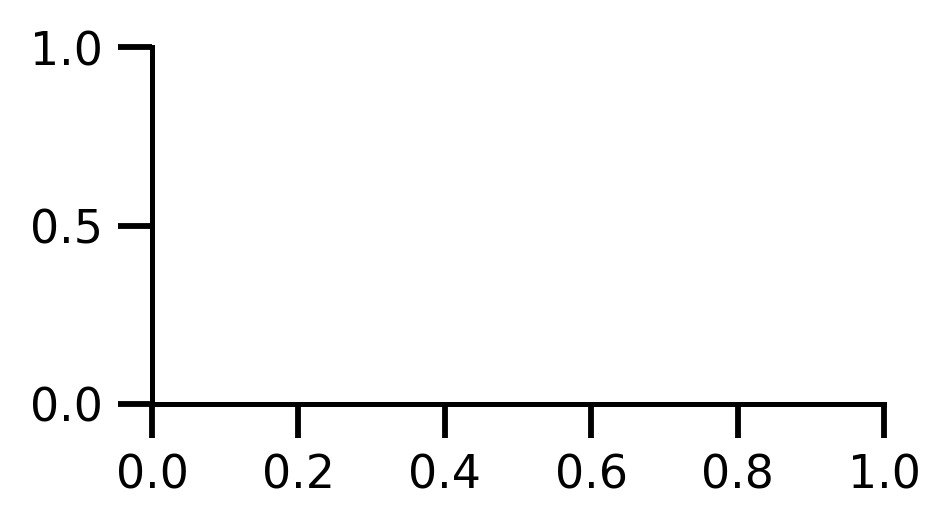

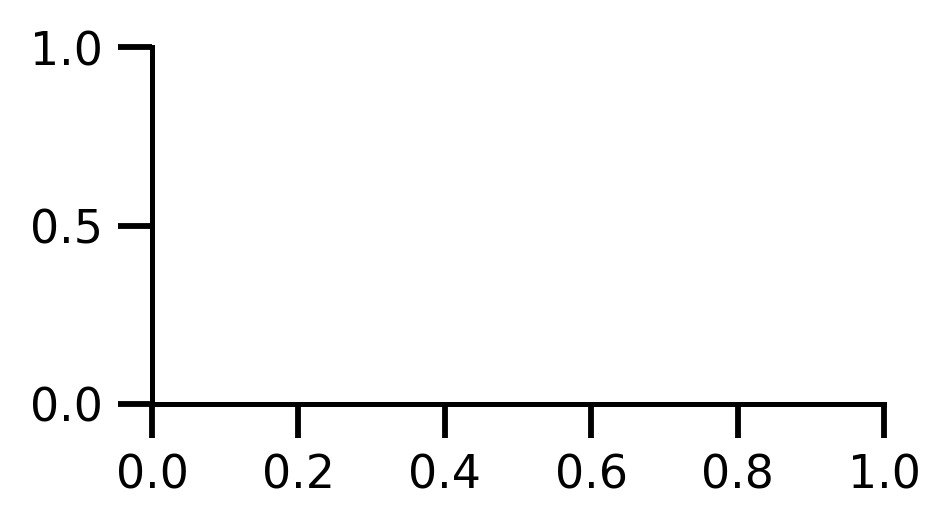

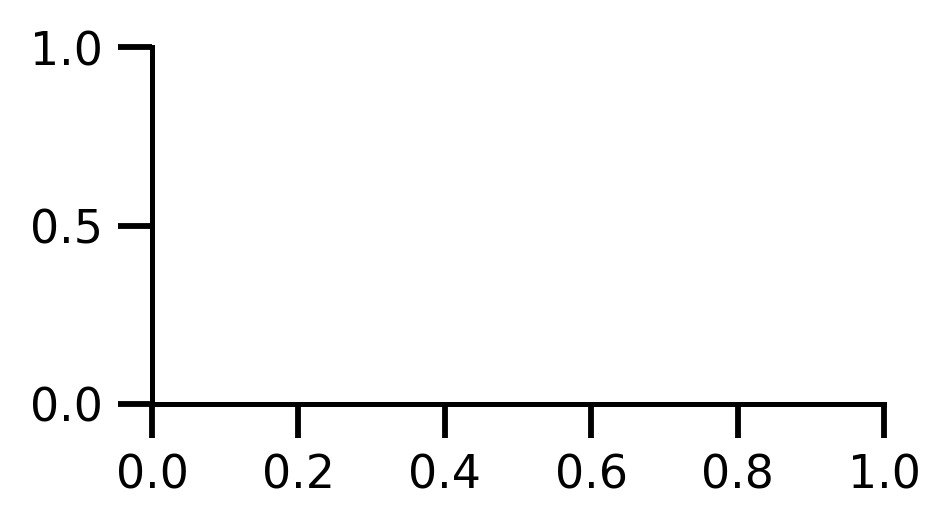

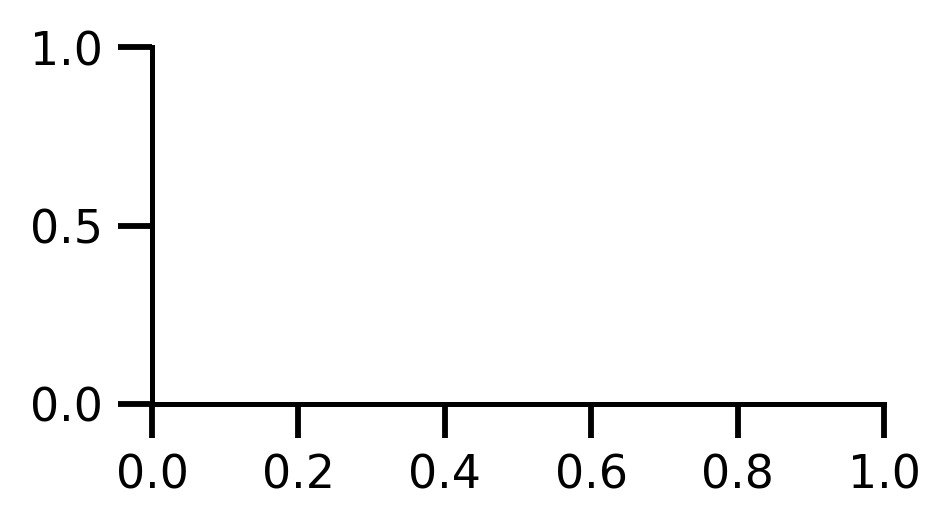

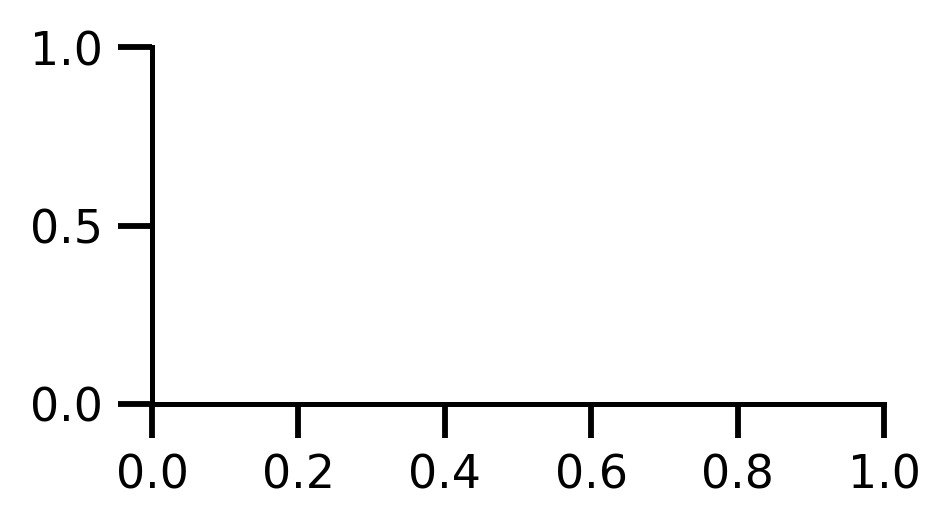

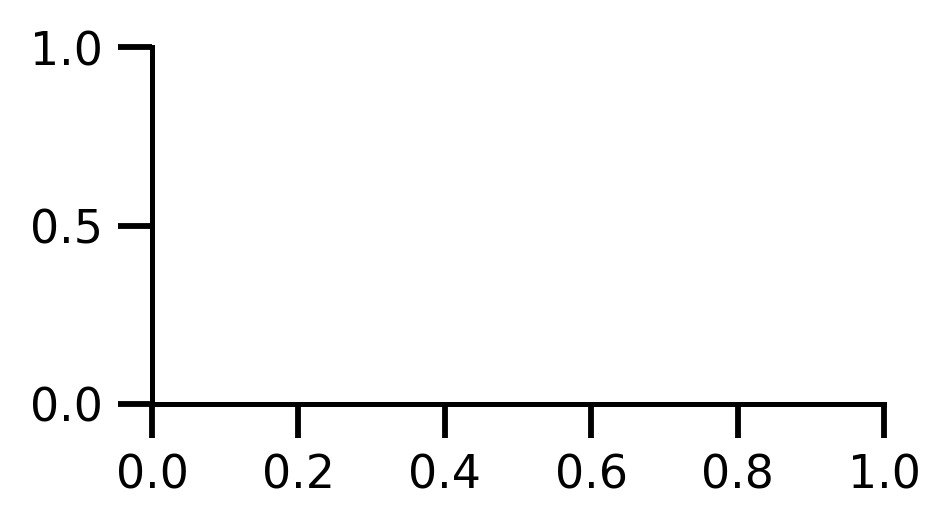

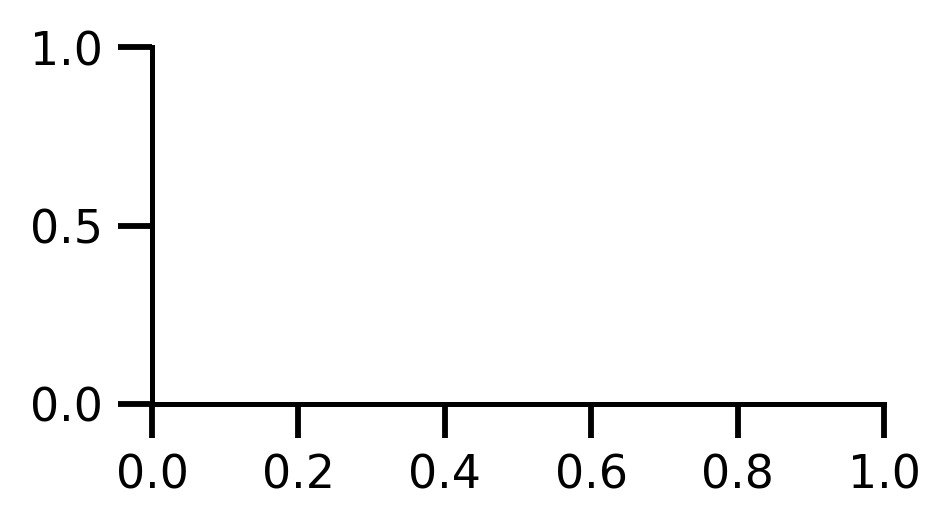

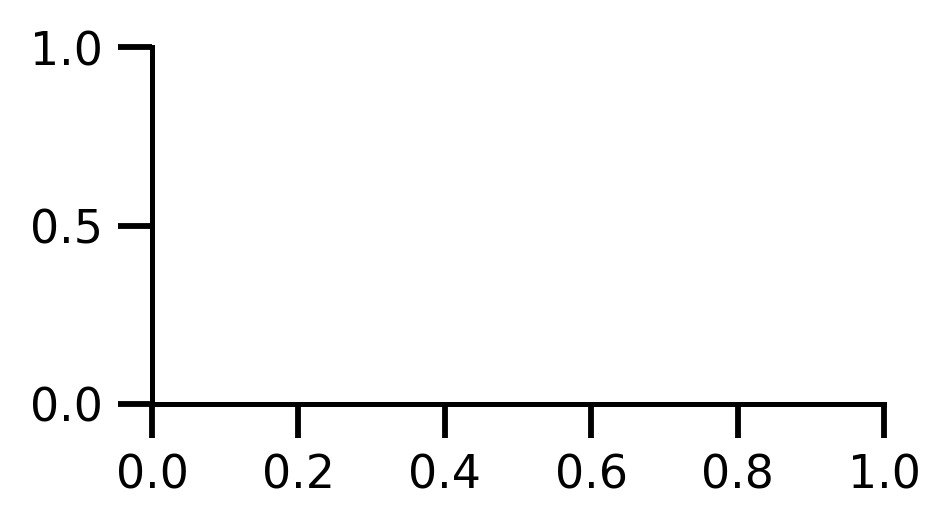

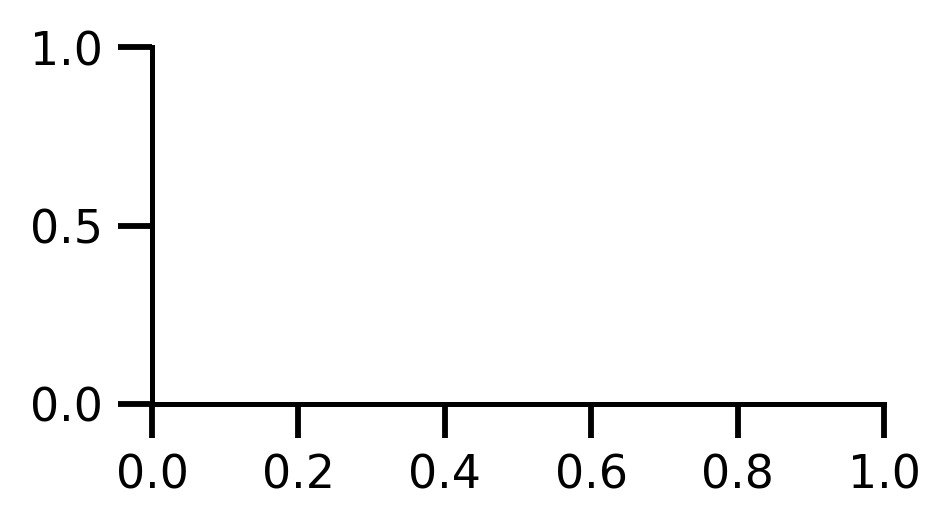

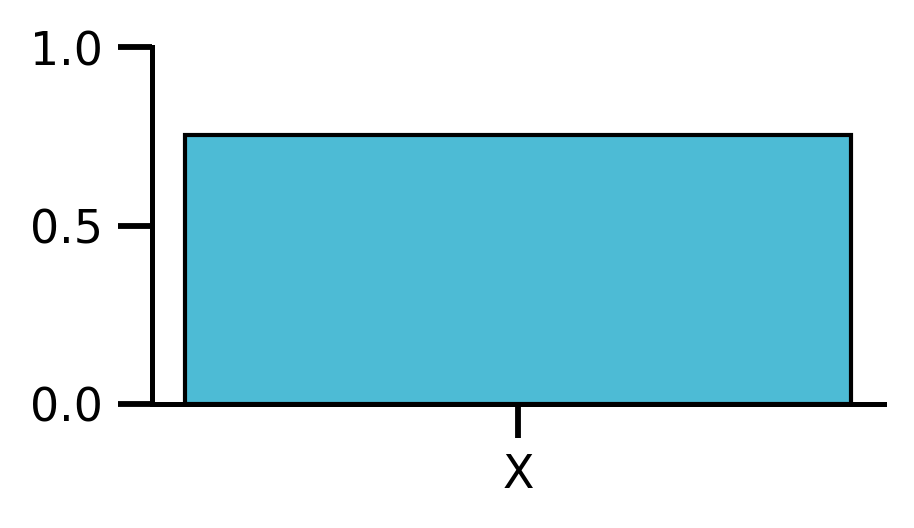

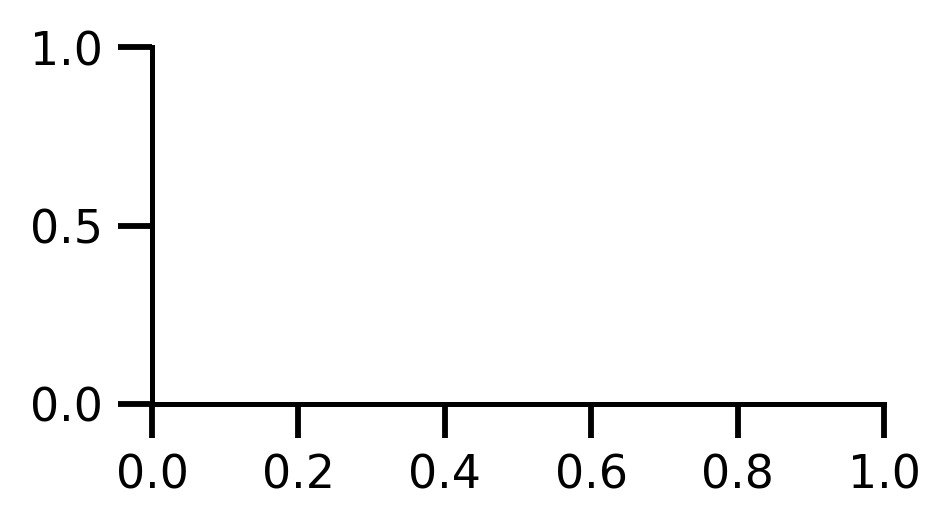

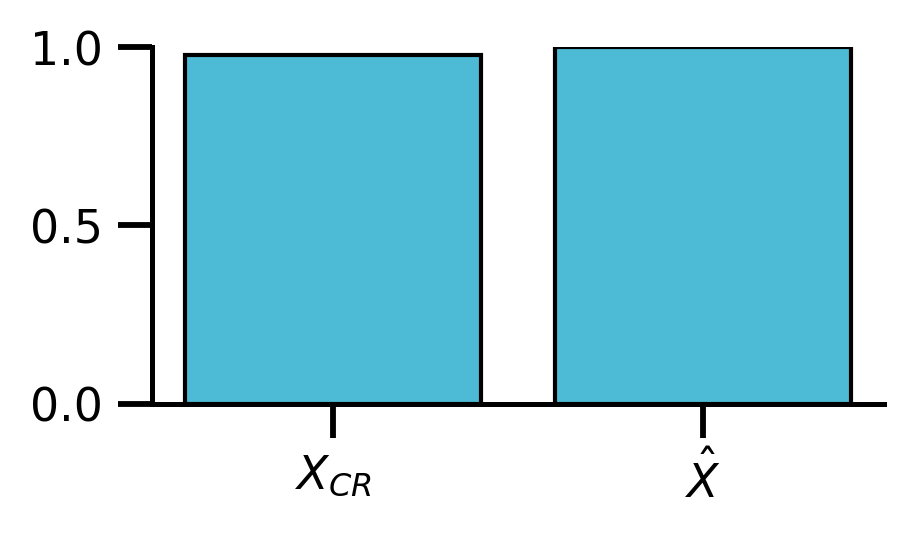

In [17]:
train_hight = len(X_train) / len(df)
test_hight = 1 - train_hight
fig_grid = fig = plt.figure(figsize=(25, 20))

# Preparig axis according to
axd = {
    name: plt.subplots(figsize=[mm_to_inch(80), mm_to_inch(40)])[1]
    for name in list("ABCDFGHIEKJL")
}

# Score X
axd["K"].bar(["X"], [score_X], color=blue)
axd["K"].set_ylim(0, 1)
axd["L"].bar([r"$X_{CR}$", r"$\hat{X}$"], [score_Xcr, score_Xhat], color=blue)
axd["L"].set_ylim(0, 1)

In [18]:
# Styling
# Remove feature names, index from most plots


important_raw_features = dt_raw.feature_importances_ > 0
tick_important_raw_features = np.arange(len(important_raw_features))[
    important_raw_features
]
names_important_raw_features = np.array(col_names[:-1])[important_raw_features]

important_removed_features = dt_taco.feature_importances_ > 0
tick_important_removed_features = np.arange(len(important_removed_features))[
    important_removed_features
]
names_important_removed_features = np.array(col_names[:-1])[important_removed_features]

idx_train = np.argsort(y_train)
idx_test = np.argsort(y_test)

cols = [
    col
    for col in col_names
    if col in names_important_raw_features or col in names_important_removed_features
]
heats = [
    X_train.iloc[idx_train, :][cols],
    y_train.values[idx_train].reshape(-1, 1),
    X_train_TaCo.iloc[idx_train, :][cols],
    y_train_TaCo.values[idx_train].reshape(-1, 1),
    X_test.iloc[idx_test, :][cols],
    y_test.values[idx_test].reshape(-1, 1),
    X_test_TaCo.iloc[idx_test, :][cols],
    y_test_TaCo.values[idx_test].reshape(-1, 1),
]


for heat, ax_label in zip(heats, list("ABCDFGHI")):
    if ax_label in list("BDGI"):
        cmap = "gray"
        kwargs = dict()
    else:
        cmap = "coolwarm"
        kwargs = dict(
            center=0,
            vmin=-3,
            vmax=3,
            cmap=cmap,
        )
    sns.heatmap(heat, cbar=False, **kwargs, ax=axd[ax_label])

for ax_name, ticks, names in zip(
    list("FH"),
    [tick_important_raw_features, tick_important_removed_features],
    [names_important_raw_features, names_important_removed_features],
):
    axd[ax_name].yaxis.set_visible(False)

for ax_name in list("BDI"):
    axd[ax_name].xaxis.set_visible(False)

for ax_name in list("ABCDEGIJ"):
    axd[ax_name].xaxis.set_visible(False)
    axd[ax_name].yaxis.set_visible(False)

walk_through_path = f"{out_base}/walk_through_composition/"
Path(walk_through_path).mkdir(exist_ok=True, parents=True)
for name, ax in axd.items():
    if name in list("JE"):
        ax.get_figure().savefig(walk_through_path + name + ".svg")
        ax.get_figure().savefig(walk_through_path + name + ".png")